# Annotated follow-along guide: Work with probability distributions in Python

This notebook contains the code used in the following instructional video: [Work with probability distributions in Python](https://www.coursera.org/learn/the-power-of-statistics/lecture/loR42/work-with-probability-distributions-in-python).


## Introduction

Throughout this notebook, we will use the normal distribution to model our data. We will also compute z-scores to find any outliers in our data. Before getting started, watch the associated instructional video and complete the in-video question. All of the code we will be implementing and related instructions are contained in this notebook.

## Overview

In this notebook, we will continue with the previous scenario in which you’re a data professional working for the Department of Education of a large nation. Recall that we are analyzing data on the literacy rate for each district, and we have already computed descriptive statistics to summarize your data. For the next part of our analysis, we want to find out if the data on district literacy rate fits a specific type of probability distribution. 

## Import packages and libraries

Before getting started, we will need to import all the required libraries and extensions. Throughout the course, we will be using pandas and numpy for operations, and matplotlib for plotting. We will also be using two Python packages that may be new to you: SciPy stats and Statsmodels.

SciPy is an open-source software you can use for solving mathematical, scientific, engineering, and technical problems. It allows you to manipulate and visualize data with a wide range of Python commands. SciPy stats is a module designed specifically for statistics.

Statsmodels is a Python package that lets you explore data, work with statistical models, and perform statistical tests. It includes an extensive list of stats functions for different types of data.

In [1]:
# Import packages
# Import the relevant Python libraries and modules needed in this lab.

### YOUR CODE HERE ###
# Import libraries and packages

# Import packages
from google.cloud import storage

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
from io import BytesIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 
from typing import List

from scipy import stats
import statsmodels.api as sm

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
#storage_client =  storage.Client.from_service_account_json('../heidless-jupyter-0-d2008100d98c.json')
storage_client =  storage.Client()


BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = storage_client.get_bucket(BUCKET_NAME)

AllCSV = []
my_prefix = 'education/'
my_file = 'education_districtwise.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV


['education/education_districtwise.csv']

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
#companies = pd.read_csv("Unicorn_Companies.csv")

# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
    
#all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

education_districtwise = all_dataframes[0]
education_districtwise.head()

education/education_districtwise.csv


,DISTNAME,STATNAME,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,OVERALL_LI
0,DISTRICT32,STATE1,13,391,104,875564.0,66.92
1,DISTRICT649,STATE1,18,678,144,1015503.0,66.93
2,DISTRICT229,STATE1,8,94,65,1269751.0,71.21
3,DISTRICT259,STATE1,13,523,104,735753.0,57.98
4,DISTRICT486,STATE1,8,359,64,570060.0,65.00


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

education_districtwise = pd.read_csv('education_districtwise.csv')
education_districtwise = education_districtwise.dropna()

**NOTE:** You can use `dropna()` to remove missing values in your data.

### Plot a histogram

The first step in trying to model your data with a probability distribution is to plot a histogram. This will help you visualize the shape of your data and determine if it resembles the shape of a specific distribution. 

Let's use matplotlib’s histogram function to plot a histogram of the district literacy rate data. Recall that the `OVERALL_LI` column contains this data. 

<Axes: >

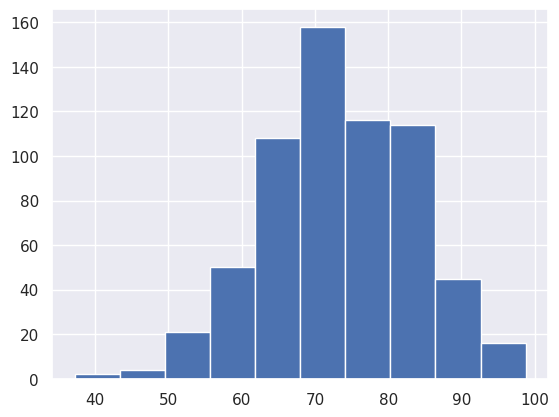

In [4]:
education_districtwise['OVERALL_LI'].hist()

### Normal distribution


The histogram shows that the distribution of the literacy rate data is bell-shaped and symmetric about the mean. The mean literacy rate, which is around 73%, is located in the center of the plot. Recall that the **normal distribution** is a continuous probability distribution that is bell-shaped and symmetrical on both sides of the mean. The shape of the histogram suggests that the normal distribution might be a good modeling option for the data. 

### Empirical rule

Since the normal distribution seems like a good fit for the district literacy rate data, we can expect the empirical rule to apply relatively well. Recall that the **empirical rule** says that for a normal distribution:

*   **68%** of the values fall within +/- 1 SD from the mean
*   **95%** of the values fall within +/- 2 SD from the mean
*   **99.7%** of the values fall within +/- 3 SD from the mean

**NOTE**: "SD" stands for standard deviation.

 In other words, we can expect that about:

*   **68%** of district literacy rates will fall within +/- 1 SD from the mean.
*   **95%** of district literacy rates will fall within +/- 2 SD from the mean.
*   **99.7%** of district literacy rates will fall within +/- 3 SD from the mean.



First, we will name two new variables to store the values for the mean and standard deviation of the district literacy rate: `mean_overall_li` and `std_overall_li`. 

In [5]:
mean_overall_li = education_districtwise['OVERALL_LI'].mean()
mean_overall_li

73.39518927444796

The mean district literacy rate is about 73.4%.

In [6]:
std_overall_li = education_districtwise['OVERALL_LI'].std()
std_overall_li

10.098460413782467

The standard deviation is about 10%.

Now, let's compute the actual percentage of district literacy rates that fall within +/- 1 SD from the mean. 

To do this, we will first name two new variables: `lower_limit` and `upper_limit`. The lower limit will be one SD *below* the mean, or the mean - (1 * SD). The upper limit will be one SD *above* the mean, or the mean + (1 * SD). To write the code for the calculations, ww will use our two previous variables, `mean_overall_li` and `std_overall_li`, for the mean and standard deviation.

Then, we will add a new line of code that tells the computer to decide if each value in the `OVERALL_LI` column is between the lower limit and upper limit. To do this, we will use the relational operators greater than or equal to (`>=`) and less than or equal to (`<=`), and the bitwise operator AND (`&`). Finally, we will use `mean()` to divide the number of values that are within 1 SD of the mean by the total number of values. 


In [6]:
lower_limit = mean_overall_li - 1 * std_overall_li
upper_limit = mean_overall_li + 1 * std_overall_li
((education_districtwise['OVERALL_LI'] >= lower_limit) & (education_districtwise['OVERALL_LI'] <= upper_limit)).mean()

0.6640378548895899

Next, let's use the same code structure to compute the actual percentage of district literacy rates that fall within +/- 2 SD from the mean.

In [7]:
lower_limit = mean_overall_li - 2 * std_overall_li
upper_limit = mean_overall_li + 2 * std_overall_li
((education_districtwise['OVERALL_LI'] >= lower_limit) & (education_districtwise['OVERALL_LI'] <= upper_limit)).mean()

0.9542586750788643

Finally, we will use the same code structure to compute the actual percentage of district literacy rates that fall within +/- 3 SD from the mean.

In [8]:
lower_limit = mean_overall_li - 3 * std_overall_li
upper_limit = mean_overall_li + 3 * std_overall_li
((education_districtwise['OVERALL_LI'] >= lower_limit) & (education_districtwise['OVERALL_LI'] <= upper_limit)).mean()

0.9968454258675079

Our values agree quite well with the empirical rule!

Our values of 66.4%, 95.4%, and 99.6% are very close to the values the empirical rule suggests: roughly 68%, 95%, and 99.7%.


Knowing that your data is normally distributed is useful for analysis because many statistical tests and machine learning models assume a normal distribution. Plus, when your data follows a normal distribution, you can use z-scores to measure the relative position of your values and find outliers in your data.

### Compute z-scores to find outliers

Recall that a **z-score** is a measure of how many standard deviations below or above the population mean a data point is. A z-score is useful because it tells you where a value lies in a distribution. 

Data professionals often use z-scores for outlier detection. Typically, they consider observations with a z-score smaller than -3 or larger than +3 as outliers. In other words, these are values that lie more than +/- 3 SDs from the mean. 

To find outliers in the data, we will first create a new column called `Z_SCORE` that includes the z-scores for each district literacy rate in your dataset. Recall that the `OVERALL_LI` column lists all the district literacy rates.  

Then, we will compute the z-scores using the function `scipy.stats.zscore()`. 

**Reference**: [scipy.stats.zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)

In [9]:
education_districtwise['Z_SCORE'] = stats.zscore(education_districtwise['OVERALL_LI'])
education_districtwise

,DISTNAME,STATNAME,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,OVERALL_LI,Z_SCORE
0,DISTRICT32,STATE1,13,391,104,875564.0,66.92,-0.641712
1,DISTRICT649,STATE1,18,678,144,1015503.0,66.93,-0.640721
2,DISTRICT229,STATE1,8,94,65,1269751.0,71.21,-0.216559
3,DISTRICT259,STATE1,13,523,104,735753.0,57.98,-1.527694
4,DISTRICT486,STATE1,8,359,64,570060.0,65.00,-0.831990
...,...,...,...,...,...,...,...,...
675,DISTRICT522,STATE29,37,876,137,5296396.0,78.05,0.461307
676,DISTRICT498,STATE29,64,1458,230,4042191.0,56.06,-1.717972
677,DISTRICT343,STATE29,59,1117,216,3483648.0,65.05,-0.827035
678,DISTRICT130,STATE29,51,993,211,3522644.0,66.16,-0.717030


Now that we have computed z-scores for our dataset,we will write some code to identify outliers, or districts with z-scores that are more than +/- 3 SDs from the mean. Let's use the relational operators greater than (`>`) and less than (`<`), and the bitwise operator OR (`|`). 

In [10]:
education_districtwise[(education_districtwise['Z_SCORE'] > 3) | (education_districtwise['Z_SCORE'] < -3)]

,DISTNAME,STATNAME,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,OVERALL_LI,Z_SCORE
434,DISTRICT461,STATE31,4,360,53,532791.0,42.67,-3.044964
494,DISTRICT429,STATE22,6,612,62,728677.0,37.22,-3.585076


Using z-scores, we can identify two outlying districts that have unusually low literacy rates: `DISTRICT461` and `DISTRICT429`. The literacy rates in these two districts are more than 3 SDs *below* the  overall mean literacy rate. 

Our analysis gives us important information to share. The government may want to provide more funding and resources to these two districts in the hopes of significantly improving literacy. 

## Conclusion

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to use Python to model your data with the normal distribution and compute z-scores to find outliers in your data. Going forward, you can start using probability distributions to model your own datasets.